# Description

This notebook evaluates how a spectral clustering method performs as a consensus function. It takes the coassociation matrix, applies several `delta` values to transform it, and computes different clustering quality measures to assess performance. An optimal `delta` value is chosen, and will be used to perform the full analysis later.

This notebook loads the `z_score_std` data version to compute two of the clustering quality measures (Calinski-Harabasz and Davies-Bouldin). The Silhouette score is computed on the ensemble distance matrix, so it is not affected by the data loaded. There are other two notebooks that perform exactly the same steps here but loading the `pca` and `umap` data versions.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

2

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=2
env: OPEN_BLAS_NUM_THREADS=2
env: NUMEXPR_NUM_THREADS=2
env: OMP_NUM_THREADS=2


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
INITIAL_RANDOM_STATE = 100000

In [6]:
# output dir for this notebook
CONSENSUS_CLUSTERING_DIR = Path(
    conf.RESULTS["CLUSTERING_DIR"], "consensus_clustering"
).resolve()

display(CONSENSUS_CLUSTERING_DIR)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/clustering/consensus_clustering')

# Load data

In [7]:
INPUT_SUBSET = "z_score_std"

In [8]:
INPUT_STEM = "projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
input_filepath = Path(
    conf.RESULTS["DATA_TRANSFORMATIONS_DIR"],
    INPUT_SUBSET,
    f"{INPUT_SUBSET}-{INPUT_STEM}.pkl",
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/data_transformations/z_score_std/z_score_std-projection-smultixcan-efo_partial-mashr-zscores.pkl')

'z_score_std-projection-smultixcan-efo_partial-mashr-zscores'

In [10]:
data = pd.read_pickle(input_filepath)

In [11]:
data.shape

(3749, 987)

In [12]:
data.head()

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,...,LV978,LV979,LV980,LV981,LV982,LV983,LV984,LV985,LV986,LV987
100001_raw-Food_weight,-0.553743,1.851060,-0.095721,0.931603,-0.515196,1.371264,-0.413165,0.729668,0.546338,0.901153,...,1.148776,1.649018,-1.375952,2.203063,0.810199,-0.987048,0.277710,-0.607613,0.572376,-0.660846
100002_raw-Energy,-1.313905,-0.421015,-0.310524,-0.201978,0.233028,0.693838,0.084129,0.572439,0.217866,1.296973,...,0.165430,0.799276,-0.361989,-0.008253,2.063780,-0.930765,-0.147007,1.601938,-0.273553,-0.560822
100003_raw-Protein,-0.645622,-0.997845,0.249039,0.256499,0.422357,0.829189,-0.169004,0.511550,0.002389,-0.057200,...,1.016791,1.019488,-2.148844,-0.065130,0.041052,-0.836118,-0.320571,1.325519,-0.341494,-0.495786
100004_raw-Fat,-0.913924,-1.837183,0.012095,-1.301315,0.205794,1.129114,0.019985,0.376660,-0.810272,0.843611,...,0.544266,0.576714,0.281731,-0.218963,1.258957,-1.131924,0.378545,0.842047,-0.622194,-0.160058
100005_raw-Carbohydrate,-0.523004,0.131379,-0.097802,-0.030526,-0.021500,-0.219116,0.668229,0.365700,1.102347,0.845625,...,-0.344740,0.079274,0.253427,0.236474,1.033895,-0.229105,0.364793,1.776714,0.190531,-1.459641


In [13]:
traits = data.index.tolist()

In [14]:
len(traits)

3749

# Ensemble (coassociation matrix)

In [15]:
input_file = Path(CONSENSUS_CLUSTERING_DIR, "ensemble_coassoc_matrix.npy").resolve()
display(input_file)

PosixPath('/media/miltondp/Elements1/projects/phenoplier/results/clustering/consensus_clustering/ensemble_coassoc_matrix.npy')

In [16]:
coassoc_matrix = np.load(input_file)

In [17]:
coassoc_matrix = pd.DataFrame(
    data=coassoc_matrix,
    index=traits,
    columns=traits,
)

In [18]:
coassoc_matrix.shape

(3749, 3749)

In [19]:
coassoc_matrix.head()

,100001_raw-Food_weight,100002_raw-Energy,100003_raw-Protein,100004_raw-Fat,100005_raw-Carbohydrate,100006_raw-Saturated_fat,100007_raw-Polyunsaturated_fat,100008_raw-Total_sugars,100009_raw-Englyst_dietary_fibre,100010-Portion_size,...,visual impairment,vitiligo,vitreous body disease,vocal cord polyp,voice disorders,wellbeing measurement AND family relationship,wheezing,whooping cough,worry measurement,wrist fracture
100001_raw-Food_weight,0.000000,0.056159,0.053895,0.076313,0.057518,0.075634,0.074728,0.057971,0.055480,0.567482,...,0.604223,0.602355,0.594564,0.603261,0.582428,0.548731,0.690641,0.599864,0.661714,0.667572
100002_raw-Energy,0.056159,0.000000,0.027400,0.044837,0.021966,0.045743,0.067482,0.031250,0.048007,0.561368,...,0.606040,0.604393,0.594337,0.606431,0.585824,0.571170,0.687644,0.601223,0.659886,0.665308
100003_raw-Protein,0.053895,0.027400,0.000000,0.046875,0.018116,0.047781,0.064764,0.032382,0.050951,0.558424,...,0.602634,0.601676,0.592525,0.603487,0.581975,0.571850,0.691102,0.597826,0.661029,0.662817
100004_raw-Fat,0.076313,0.044837,0.046875,0.000000,0.045516,0.004755,0.046196,0.028306,0.057971,0.551857,...,0.590372,0.589674,0.578256,0.595788,0.571332,0.585902,0.692254,0.588315,0.667429,0.666667
100005_raw-Carbohydrate,0.057518,0.021966,0.018116,0.045516,0.000000,0.046196,0.067935,0.025589,0.050045,0.559783,...,0.605813,0.604393,0.593205,0.604846,0.584692,0.574569,0.687414,0.600543,0.657143,0.662817


In [20]:
dist_matrix = coassoc_matrix

# Clustering

In [21]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from clustering.utils import compute_performance

## `delta` parameter (gaussian kernel)

### `delta=1.0`

In [22]:
delta = 1.0

In [23]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")
    
    sim_matrix = np.exp(- dist_matrix ** 2 / (2. * delta ** 2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [24]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3179
1     570
dtype: int64

In [25]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.249'

'Calinski-Harabasz (higher is better): 133.181'

'Davies-Bouldin (lower is better): 4.253'

For `delta=1.0`, the algorithm works/converges fine with this data version.

### `delta>1.0`

In [26]:
delta = 10.0

In [27]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")
    
    sim_matrix = np.exp(- dist_matrix ** 2 / (2. * delta ** 2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        #         eigen_tol=1e-3,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [28]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3147
1     602
dtype: int64

In [29]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.243'

'Calinski-Harabasz (higher is better): 128.603'

'Davies-Bouldin (lower is better): 4.389'

For `delta` values larger than `1.0`, quality measures go slightly down.

### `delta<1.0`

In [30]:
delta = 0.20

In [31]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")
    
    sim_matrix = np.exp(- dist_matrix ** 2 / (2. * delta ** 2))

    clus = SpectralClustering(
        eigen_solver="arpack",
#         eigen_tol=1e-3,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [32]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3708
1      41
dtype: int64

In [33]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.428'

'Calinski-Harabasz (higher is better): 154.143'

'Davies-Bouldin (lower is better): 1.263'

For `delta` values smaller than `1.0`, quality measures improve.

### `delta<<<1.0`

In [34]:
delta = 0.10

In [35]:
with warnings.catch_warnings():
    warnings.filterwarnings("always")
    
    sim_matrix = np.exp(- dist_matrix ** 2 / (2. * delta ** 2))

    clus = SpectralClustering(
        eigen_solver="arpack",
        eigen_tol=1e-4,
        n_clusters=2,
        n_init=10,
        affinity="precomputed",
        random_state=INITIAL_RANDOM_STATE,
    )

    part = clus.fit_predict(sim_matrix)

In [36]:
# show number of clusters and their size
pd.Series(part).value_counts()

0    3744
1       5
dtype: int64

In [37]:
compute_performance(data, part, data_distance_matrix=dist_matrix)

'Silhouette (higher is better): 0.364'

'Calinski-Harabasz (higher is better): 40.633'

'Davies-Bouldin (lower is better): 1.045'

For `delta` values around `0.10` the algorithm does not converge, and I need to force convergence with `eigen_tol=1e-4`.

Quality measures in general go down.

## Extended test

In [38]:
from clustering.methods import DeltaSpectralClustering

In [39]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_RANGE"] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40]
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10
CLUSTERING_OPTIONS["DELTAS"] = [
    5.00,
    2.00,
    1.00,
    0.90,
    0.75,
    0.50,
    0.30,
    0.25,
    0.20,
]

display(CLUSTERING_OPTIONS)

{'K_RANGE': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40],
 'N_REPS_PER_K': 5,
 'KMEANS_N_INIT': 10,
 'DELTAS': [5.0, 2.0, 1.0, 0.9, 0.75, 0.5, 0.3, 0.25, 0.2]}

In [40]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in CLUSTERING_OPTIONS["K_RANGE"]:
    for delta_value in CLUSTERING_OPTIONS["DELTAS"]:
        for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
            clus = DeltaSpectralClustering(
                eigen_solver="arpack",
                n_clusters=k,
                n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
                affinity="precomputed",
                delta=delta_value,
                random_state=random_state,
            )

            method_name = type(clus).__name__
            CLUSTERERS[f"{method_name} #{idx}"] = clus

            random_state = random_state + 1
            idx = idx + 1

In [41]:
display(len(CLUSTERERS))

630

In [42]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('DeltaSpectralClustering #0', DeltaSpectralClustering(delta=5.0))

('DeltaSpectralClustering #1', DeltaSpectralClustering(delta=5.0))

In [43]:
clustering_method_name = method_name
display(clustering_method_name)

'DeltaSpectralClustering'

## Generate ensemble

In [44]:
import tempfile
from clustering.ensemble import generate_ensemble

In [45]:
# generate a temporary folder where to store the ensemble and avoid computing it again
ensemble_folder = Path(
    tempfile.gettempdir(),
    f"pre_cluster_analysis",
    clustering_method_name,
).resolve()
ensemble_folder.mkdir(parents=True, exist_ok=True)

In [46]:
ensemble_file = Path(
    ensemble_folder,
    generate_result_set_name(
        CLUSTERING_OPTIONS, prefix=f"ensemble-", suffix=".pkl"
    ),
)
display(ensemble_file)

PosixPath('/tmp/pre_cluster_analysis/DeltaSpectralClustering/ensemble-DELTAS_50_20_10_09_075_05_03_025_02-KMEANS_N_INIT_10-K_RANGE_2_4_6_8_10_12_14_16_18_20_25_30_35_40-N_REPS_PER_K_5.pkl')

In [47]:
if ensemble_file.exists():
    display(f"Ensemble file exists")
    ensemble = pd.read_pickle(ensemble_file)
else:
    ensemble = generate_ensemble(
        dist_matrix,
        CLUSTERERS,
        attributes=["n_clusters", "delta"],
    )

100%|██████████| 630/630 [19:34<00:00,  1.86s/it]


In [48]:
ensemble.shape

(630, 4)

In [49]:
ensemble.head()

,clusterer_params,partition,n_clusters,delta
clusterer_id,,,,
DeltaSpectralClustering #0,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.0
DeltaSpectralClustering #1,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.0
DeltaSpectralClustering #2,{'delta': 5.0},"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,5.0
DeltaSpectralClustering #3,{'delta': 5.0},"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,5.0
DeltaSpectralClustering #4,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.0


In [50]:
ensemble["delta"] = ensemble["delta"].apply(lambda x: f"{x:.2f}")

In [51]:
ensemble["n_clusters"].value_counts()

40    45
35    45
30    45
25    45
20    45
18    45
16    45
14    45
12    45
10    45
8     45
6     45
4     45
2     45
Name: n_clusters, dtype: int64

In [52]:
_tmp = ensemble["n_clusters"].value_counts().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"] * len(CLUSTERING_OPTIONS["DELTAS"])
)

In [53]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    630.000000
mean      17.142857
std       11.271131
min        2.000000
25%        8.000000
50%       15.000000
75%       25.000000
max       40.000000
Name: n_clusters, dtype: float64

### Testing

In [54]:
assert ensemble_stats["min"] > 1

In [55]:
assert not ensemble["n_clusters"].isna().any()

In [56]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [57]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [58]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

In [59]:
# check that the number of clusters in the partitions are the expected ones
_real_k_values = ensemble["partition"].apply(lambda x: np.unique(x).shape[0])
display(_real_k_values)
assert np.all(ensemble["n_clusters"].values == _real_k_values.values)

clusterer_id
DeltaSpectralClustering #0       2
DeltaSpectralClustering #1       2
DeltaSpectralClustering #2       2
DeltaSpectralClustering #3       2
DeltaSpectralClustering #4       2
                                ..
DeltaSpectralClustering #625    40
DeltaSpectralClustering #626    40
DeltaSpectralClustering #627    40
DeltaSpectralClustering #628    40
DeltaSpectralClustering #629    40
Name: partition, Length: 630, dtype: int64

### Add clustering quality measures

In [60]:
ensemble = ensemble.assign(
    si_score=ensemble["partition"].apply(lambda x: silhouette_score(dist_matrix, x, metric="precomputed")),
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x)),
    db_score=ensemble["partition"].apply(lambda x: davies_bouldin_score(data, x)),
)

In [61]:
ensemble.shape

(630, 7)

In [62]:
ensemble.head()

,clusterer_params,partition,n_clusters,delta,si_score,ch_score,db_score
clusterer_id,,,,,,,
DeltaSpectralClustering #0,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.00,0.242625,128.603203,4.388969
DeltaSpectralClustering #1,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.00,0.242625,128.603203,4.388969
DeltaSpectralClustering #2,{'delta': 5.0},"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,5.00,0.242625,128.603203,4.388969
DeltaSpectralClustering #3,{'delta': 5.0},"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,5.00,0.242625,128.603203,4.388969
DeltaSpectralClustering #4,{'delta': 5.0},"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,5.00,0.242625,128.603203,4.388969


### Save

In [63]:
ensemble.to_pickle(ensemble_file)

# Cluster quality

In [64]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters", "delta"]).mean()
    display(_df)

si_score    ch_score   db_score
n_clusters delta                                 
2          0.20   0.427525  154.143308   1.263226
           0.25   0.428439  152.424146   1.250389
           0.30   0.428439  152.424146   1.250389
           0.50   0.263322  142.674384   3.950004
           0.75   0.252516  135.887281   4.174068
           0.90   0.249902  133.875775   4.232265
           1.00   0.248749  133.180946   4.253231
           2.00   0.244404  130.185128   4.343579
           5.00   0.242625  128.603203   4.388969
4          0.20   0.382459   67.820186   1.166453
           0.25   0.383548   73.579195   1.148600
           0.30   0.424656   66.931803   1.513232
           0.50   0.199576   90.532883   5.373453
           0.75   0.184060   88.174078   5.726250
           0.90   0.183101   86.786571   5.808677
           1.00   0.180977   85.882271   5.945111
           2.00   0.180781   82.563508   6.089100
           5.00   0.180488   82.101894   6.106092
6          0.20   0.278484   64.768133   2.131058
           0.25   0.277664   65.041097   2.157278
           0.30   0.276948   62.959933   2.258413
           0.50   0.064235   58.252583  15.053707
           0.75   0.068344   54.058648  16.562424
           0.90   0.068433   53.718184  16.563627
           1.00   0.068581   53.373439  16.584230
           2.00   0.069271   50.674020  16.551476
           5.00   0.069425   49.907354  16.652268
8          0.20   0.374526   56.197349   1.711392
           0.25   0.378640   54.811376   1.561313
           0.30   0.235342   56.702628   2.401609
           0.50   0.076589   51.384274  14.019482
           0.75   0.075782   50.315566  14.109908
           0.90   0.071693   40.669771  15.791255
           1.00   0.070781   40.237362  15.693195
           2.00   0.072265   38.514346  15.897169
           5.00   0.072009   38.011595  15.929076
10         0.20   0.357620   49.232282   1.499271
           0.25   0.222965   49.140634   2.203900
           0.30   0.246032   50.821559   2.592345
           0.50   0.079614   39.077950  14.138487
           0.75   0.076941   38.930533  13.670217
           0.90   0.077102   38.848807  13.686147
           1.00   0.076801   38.820031  13.711908
           2.00   0.072286   31.560557  14.741388
           5.00   0.072967   29.827952  14.854868
12         0.20   0.227325   45.107724   1.937543
           0.25   0.237612   43.663642   1.877258
           0.30   0.163992   43.508880   4.376077
           0.50   0.083869   34.845082  12.636575
           0.75   0.079932   32.210755  13.712973
           0.90   0.079344   32.175842  13.693940
           1.00   0.079175   32.105141  13.673481
           2.00   0.078788   31.875609  13.633692
           5.00   0.080214   30.922872  13.685953
14         0.20   0.274823   39.828880   1.269014
           0.25   0.238917   40.153075   1.791218
           0.30   0.141021   39.601029   4.626385
           0.50   0.085860   30.136598  12.723231
           0.75   0.085094   28.642324  13.085111
           0.90   0.084411   28.555769  13.084284
           1.00   0.084417   28.478891  13.092148
           2.00   0.082363   27.578013  13.389443
           5.00   0.084238   27.015565  13.539134
16         0.20   0.211533   37.579692   1.662810
           0.25   0.232423   37.331435   1.669274
           0.30   0.162359   36.227366   3.981769
           0.50   0.100239   26.629773  12.627424
           0.75   0.097533   25.156529  13.126085
           0.90   0.097785   25.038066  13.189569
           1.00   0.096574   24.957617  13.167103
           2.00   0.093288   24.623896  13.182650
           5.00   0.096695   24.460794  13.227146
18         0.20   0.212348   35.123145   1.691347
           0.25   0.232169   35.015320   1.699460
           0.30   0.105787   32.882166   5.744594
           0.50   0.107428   24.882300  11.780772
           0.75   0.106236   23.139609  12.680467
           0.90   0.106723   22.331883  12.825450
           1.00   

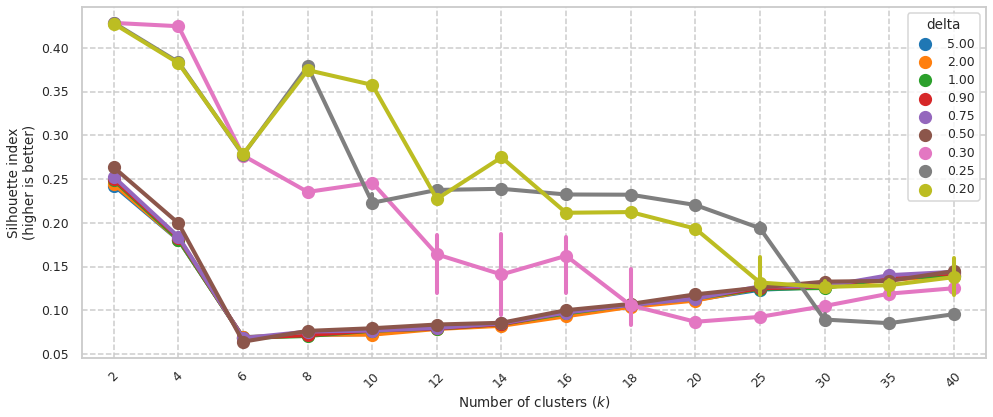

In [65]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="si_score", hue="delta")
    ax.set_ylabel("Silhouette index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

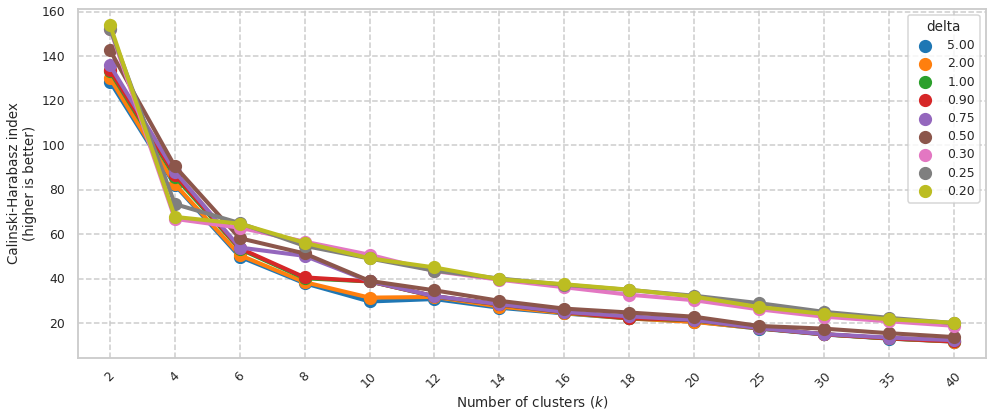

In [66]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score", hue="delta")
    ax.set_ylabel("Calinski-Harabasz index\n(higher is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

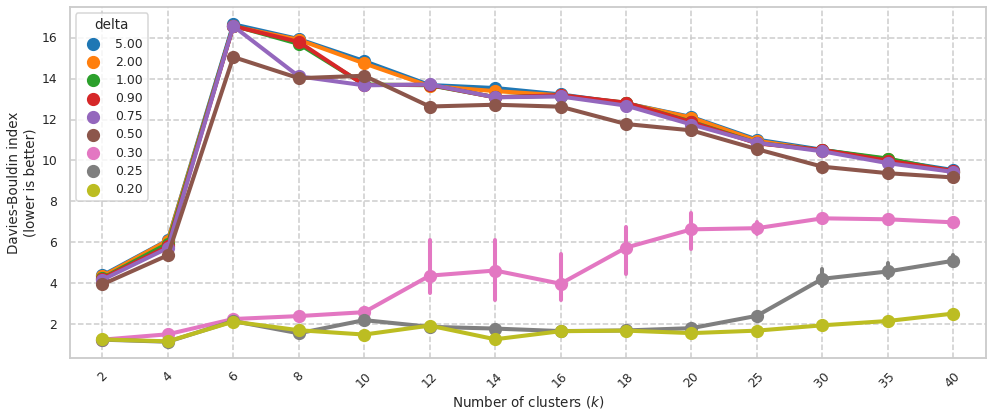

In [67]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="db_score", hue="delta")
    ax.set_ylabel("Davies-Bouldin index\n(lower is better)")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [68]:
parts = ensemble.groupby(["delta", "n_clusters"]).apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [69]:
parts.shape

(126,)

In [70]:
parts.head()

delta  n_clusters
0.20   2             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       4             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       6             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       8             [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
       10            [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dtype: object

In [71]:
parts.iloc[0].shape

(5, 3749)

In [72]:
assert np.all(
    [
        parts.loc[k].shape == (int(CLUSTERING_OPTIONS["N_REPS_PER_K"]), data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [73]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import squareform, pdist

In [74]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="n_clusters"
)

In [75]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

0.20  2    1.0
0.30  2    1.0
1.00  2    1.0
      4    1.0
0.90  4    1.0
      2    1.0
0.75  6    1.0
      4    1.0
      2    1.0
0.50  4    1.0
2.00  2    1.0
0.50  2    1.0
0.30  8    1.0
      4    1.0
      6    1.0
Name: n_clusters, dtype: float64

In [76]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)
parts_ari_df.index.rename(["gamma", "n_clusters"], inplace=True)

In [77]:
parts_ari_df.shape

(126, 10)

In [78]:
_n_total_parts = int(
    CLUSTERING_OPTIONS["N_REPS_PER_K"]
)  # * len(CLUSTERING_OPTIONS["GAMMAS"]))

assert int(_n_total_parts * (_n_total_parts - 1) / 2) == parts_ari_df.shape[1]

In [79]:
parts_ari_df.head()

0    1    2    3    4    5    6    7    8    9
gamma n_clusters                                                  
0.20  2           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      4           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      6           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      8           1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
      10          1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

## Stability plot

In [80]:
parts_ari_df_plot = (
    parts_ari_df.stack().reset_index().rename(columns={"level_2": "idx", 0: "ari"})
)

In [81]:
parts_ari_df_plot.dtypes

gamma          object
n_clusters      int64
idx             int64
ari           float64
dtype: object

In [82]:
parts_ari_df_plot.head()

,gamma,n_clusters,idx,ari
0,0.20,2,0,1.0
1,0.20,2,1,1.0
2,0.20,2,2,1.0
3,0.20,2,3,1.0
4,0.20,2,4,1.0


In [83]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = parts_ari_df_plot.groupby(["n_clusters", "gamma"]).mean()
    display(_df)

idx       ari
n_clusters gamma               
2          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  1.000000
           0.50   4.5  1.000000
           0.75   4.5  1.000000
           0.90   4.5  1.000000
           1.00   4.5  1.000000
           2.00   4.5  1.000000
           5.00   4.5  1.000000
4          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  1.000000
           0.50   4.5  1.000000
           0.75   4.5  1.000000
           0.90   4.5  1.000000
           1.00   4.5  1.000000
           2.00   4.5  0.993919
           5.00   4.5  1.000000
6          0.20   4.5  1.000000
           0.25   4.5  1.000000
           0.30   4.5  1.000000
           0.50   4.5  0.996792
           0.75   4.5  1.000000
           0.90   4.5  0.999411
           1.00   4.5  0.995154
           2.00   4.5  0.984092
           5.00   4.5  0.991213
8          0.20   4.5  1.000000
           0.25   4.5  0.999976
           0.30   4.5  1.000000
           0.50   4.5  0.984497
           0.75   4.5  0.982437
           0.90   4.5  0.980833
           1.00   4.5  0.966565
           2.00   4.5  0.993389
           5.00   4.5  0.986965
10         0.20   4.5  1.000000
           0.25   4.5  0.899873
           0.30   4.5  0.998005
           0.50   4.5  0.986723
           0.75   4.5  0.976297
           0.90   4.5  0.979890
           1.00   4.5  0.987266
           2.00   4.5  0.976459
           5.00   4.5  0.977611
12         0.20   4.5  0.985296
           0.25   4.5  0.998916
           0.30   4.5  0.807272
           0.50   4.5  0.995121
           0.75   4.5  0.992760
           0.90   4.5  0.992068
           1.00   4.5  0.993909
           2.00   4.5  0.969995
           5.00   4.5  0.986701
14         0.20   4.5  0.996079
           0.25   4.5  0.998980
           0.30   4.5  0.675522
           0.50   4.5  0.870772
           0.75   4.5  0.988704
           0.90   4.5  0.989760
           1.00   4.5  0.972102
           2.00   4.5  0.884660
           5.00   4.5  0.820064
16         0.20   4.5  0.990620
           0.25   4.5  0.995089
           0.30   4.5  0.747181
           0.50   4.5  0.986218
           0.75   4.5  0.847363
           0.90   4.5  0.863503
           1.00   4.5  0.830640
           2.00   4.5  0.866661
           5.00   4.5  0.861173
18         0.20   4.5  0.967120
           0.25   4.5  0.996188
           0.30   4.5  0.502074
           0.50   4.5  0.847194
           0.75   4.5  0.797804
           0.90   4.5  0.861331
           1.00   4.5  0.861117
           2.00   4.5  0.955990
           5.00   4.5  0.922931
20         0.20   4.5  0.855124
           0.25   4.5  0.974847
           0.30   4.5  0.567486
           0.50   4.5  0.947888
           0.75   4.5  0.888675
           0.90   4.5  0.811565
           1.00   4.5  0.870871
           2.00   4.5  0.821736
           5.00   4.5  0.798859
25         0.20   4.5  0.980165
           0.25   4.5  0.924024
           0.30   4.5  0.499094
           0.50   4.5  0.815098
           0.75   4.5  0.834067
           0.90   4.5  0.775615
           1.00   4.5  0.783037
           2.00   4.5  0.787075
           5.00   4.5  0.794628
30         0.20   4.5  0.859143
           0.25   4.5  0.304671
           0.30   4.5  0.512587
           0.50   4.5  0.811116
           0.75   4.5  0.810547
           0.90   4.5  0.755169
           1.00   4.5  0.782872
           2.00   4.5  0.748817
           5.00   4.5  0.780548
35         0.20   4.5  0.927005
           0.25   4.5  0.360036
           0.30   4.5  0.594149
           0.50   4.5  0.823520
           0.75   4.5  0.820176
           0.90   4.5  0.829968
           1.00   4.5  0.767713
           2.00   4.5  0.799027
           5.00   4.5  0.819577
40         0.20   4.5  0.774045
           0.25   4.5  0.347876
           0.30   4.5  0.756114
           0.50   4.5  0.792539
           0.75   4.5  0.793490
           0.90   4.5  0.774088
           1.00   

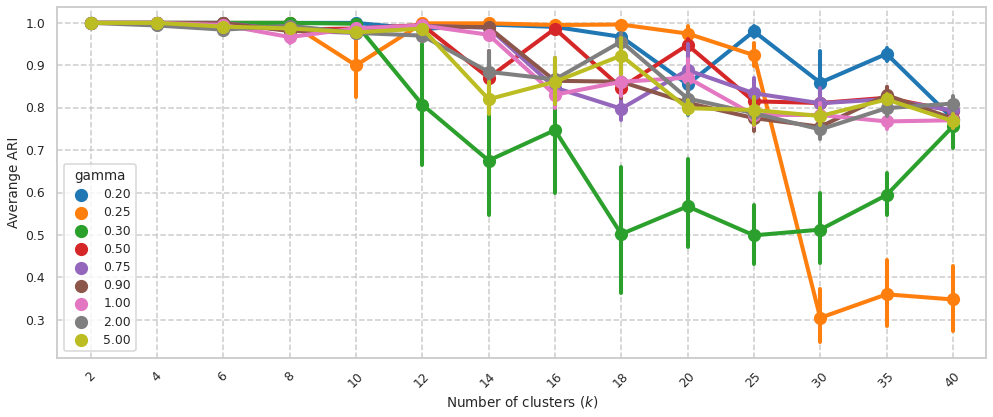

In [84]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="n_clusters", y="ari", hue="gamma")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

**CONCLUSION:** the best values for the `delta` parameter seem to be `0.20`, `0.25` and `0.30`. I will also consider `0.50`, since seem to yield potentially good results when `n_clusters` is high (see `umap` results).